In [17]:
import os, sys
os.sys.path.append('..')
from recommender.utils import mongodbutils as mdb
from recommender.utils.ItemMetadata import ExplicitDataFromCSV
from recommender.utils.eval_utils import compute_auc, compute_ap
from recommender.recommender.recommenderMF import RecommenderMF
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [18]:
df_train = pd.read_csv('D:/PycharmProjects/recommender/data/ml-20m/ratings_train.csv', index_col=0)
df_test = pd.read_csv('D:/PycharmProjects/recommender/data/ml-20m/ratings_test.csv', index_col=0)

D:\python\Python35\lib\site-packages\numpy\lib\arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


In [19]:
ratings_csv = 'D:/PycharmProjects/recommender/data/ml-20m/ratings_sanitized.csv'
user_map_csv = 'D:/PycharmProjects/recommender/data/ml-20m/user_map.csv'
item_map_csv = 'D:/PycharmProjects/recommender/data/ml-20m/item_map.csv'
md_csv = 'D:/PycharmProjects/recommender/data/ml-20m/metadata.csv'
stats_csv = 'D:/PycharmProjects/recommender/data/ml-20m/stats.csv'
d = ExplicitDataFromCSV(True, ratings_csv=ratings_csv, user_map_csv=user_map_csv, item_map_csv=item_map_csv, md_csv=md_csv, stats_csv=stats_csv)

In [20]:
# ratings_csv = 'D:/PycharmProjects/recommender/data/ml-latest-small/ratings.csv'
# movies_csv = 'D:/PycharmProjects/recommender/data/ml-latest-small/movies.csv'
# d = ExplicitDataFromCSV(False,
#                         ratings_csv=ratings_csv, r_item_col='movieId', r_user_col='userId',
#                         r_rating_col='rating',
#                         metadata_csv=movies_csv, m_item_col='movieId')
# d.save('D:\\PycharmProjects\\recommender\\data\\ml-latest-small')

In [21]:
model_path = 'D:/PycharmProjects/recommender/recommender/models/model/07201914185949/'
rmf = RecommenderMF(mode='predict', model_path=model_path)

INFO:tensorflow:Restoring parameters from D:/PycharmProjects/recommender/recommender/models/model/07201914185949/variables\variables


In [23]:
F = rmf.predict(np.array(df_test['user']), np.array(df_test['item']))
np.sqrt(np.mean(np.power(F['rhat'] - df_test['rating'],2)))

0.9100883109332639

In [24]:
A = df_train
A = df_train.groupby('item').agg('mean')
A = A.merge(d.stats, on='item')
A = A[A['user_y']>10]
A.head()

,rating,user_x,user_y
item,,,
0,3.918555,69191.838443,49695
1,3.213763,69282.373643,22243
2,3.150683,69095.217659,12735
3,2.862000,69595.959111,2756
4,3.058737,68964.302292,12161


In [26]:
df_test_rel = df_test[df_test['rating']>3.0]
df_test_rel.head()

,rating,item,user
3218737,5.0,352,21994
11118451,4.0,903,76830
5956816,4.0,2244,41069
11973805,4.0,108,82685
13644042,5.0,587,94263


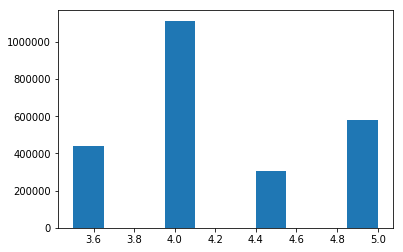

In [27]:
plt.hist(df_test_rel['rating'])
plt.show()

In [96]:
# remove train info from testing
user = 90000
df_test_excl = df_train.loc[df_train.user==user]

rec = rmf.recommend(user)[0]
rec_filt = pd.DataFrame({'item': rec}, )
rec_filt = pd.merge(rec_filt, df_test_excl ,on="item", how="outer",indicator=True)
rec_filt = rec_filt.loc[rec_filt._merge=='left_only']['item']
print(len(rec), len(rec_filt))

26744 26674


26674 10


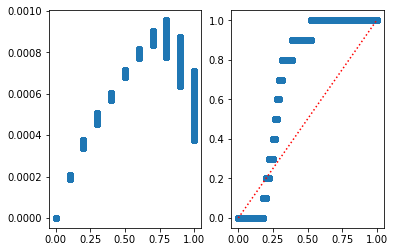

In [97]:
pos = df_test_rel[df_test_rel['user']==user]['item']

pos = set(pos)
n = len(rec_filt)
p = len(pos)

print(n, p)

f = n - p
tp = 0
fp = 0
prec = []
sens = []
fpr = []
tp_pos = []

for i, r in enumerate(rec_filt):
    if r in pos:
        tp += 1
        tp_pos.append(i)
    else:
        fp += 1
    prec.append(tp/(i+1))
    sens.append(tp/p)
    fpr.append(fp/f)

plt.subplot(121)
plt.plot(sens, prec, 'o')
plt.subplot(122)
plt.plot(fpr, sens, 'o')
plt.plot([0,1], [0,1], 'r:')
plt.show()

In [98]:
prec = np.array(prec)
sens = np.array(sens)
fpr = np.array(fpr)
dsens = sens[1:] - sens[:-1]
dfpr = fpr[1:] - fpr[:-1]
print(np.sum(prec[1:]*dsens))
print(np.sum(sens[1:]*dfpr))

0.0006665204645384932
0.7093684368436843


In [99]:
compute_auc(rmf, user, df_test_rel, df_train)

0.7093684368436843

In [100]:
compute_ap(rmf, user, df_test_rel, df_train)

0.0006665204645384932

In [90]:
item = 293

In [91]:
a,s = rmf.similar_to(item)

(26744, 20) (20,)


In [92]:
d.md_df.loc[d.md_df['title'].map(lambda t: t.startswith('Pulp Fiction'))]

,title,genres
item_cat,,
293,Pulp Fiction (1994),Comedy|Crime|Drama|Thriller


In [93]:
md = d.fetch_md(a).merge(d.stats, right_index=True, left_on='item_cat')
md[md['user'] > 100]

,title,genres,user
item_cat,,,
24,Leaving Las Vegas (1995),Drama|Romance,21553
1188,Alien (1979),Horror|Sci-Fi,30933
2606,Run Lola Run (Lola rennt) (1998),Action|Crime,17029
505,"Piano, The (1993)",Drama|Romance,17068
2873,Fight Club (1999),Action|Crime|Drama|Thriller,40106
537,Blade Runner (1982),Action|Sci-Fi|Thriller,30526
84,Angels and Insects (1995),Drama|Romance,2714
1187,Goodfellas (1990),Crime|Drama,26406
1260,This Is Spinal Tap (1984),Comedy,16054
